In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score 

In [2]:
df_final = pd.read_csv("df_final.csv")

In [3]:
cat_cols = ['os', 'browser','slot_id', "ssp_uid",'carrier_name', 'region','creative_type','sponsor_id','campaign_id','creative_id',"is_rt", 'request_hour',
       'request_month', 'request_day', 'request_dayofweek']
for c in cat_cols:
    vv, obj = pd.factorize(df_final[c])
    df_final[c] = vv

In [4]:
df_final = df_final.fillna(0)

In [5]:
from scipy.misc import derivative
def focal_loss_lgb(y_pred, dtrain, alpha, gamma):
  a,g = alpha, gamma
  y_true = dtrain.label
  def fl(x,t):
  	p = 1/(1+np.exp(-x))
  	return -( a*t + (1-a)*(1-t) ) * (( 1 - ( t*p + (1-t)*(1-p)) )**g) * ( t*np.log(p)+(1-t)*np.log(1-p) )
  partial_fl = lambda x: fl(x, y_true)
  grad = derivative(partial_fl, y_pred, n=1, dx=1e-6)
  hess = derivative(partial_fl, y_pred, n=2, dx=1e-6)
  return grad, hess

def focal_loss_lgb_eval_error(y_pred, dtrain, alpha, gamma):
  a,g = alpha, gamma
  y_true = dtrain.label
  p = 1/(1+np.exp(-y_pred))
  loss = -( a*y_true + (1-a)*(1-y_true) ) * (( 1 - ( y_true*p + (1-y_true)*(1-p)) )**g) * ( y_true*np.log(p)+(1-y_true)*np.log(1-p) )
  # (eval_name, eval_result, is_higher_better)
  return 'focal_loss', np.mean(loss), False
focal_loss = lambda x,y: focal_loss_lgb(x, y, alpha=0.25, gamma=1.)
focal_loss_eval = lambda x,y: focal_loss_lgb_eval_error(x, y, alpha=0.25, gamma=1.)

In [6]:
!conda install -y -c conda-forge lightgbm

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.6.14
  latest version: 4.8.0rc0

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /usr/local/envs/py3env

  added / updated specs:
    - lightgbm


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _libgcc_mutex-0.1          |             main           3 KB  defaults
    ca-certificates-2019.9.11  |       hecc5488_0         144 KB  conda-forge
    certifi-2018.8.24          |        py35_1001         139 KB  conda-forge
    lightgbm-2.2.0             |   py35hfc679d8_0         1.1 MB  conda-forge
    openssl-1.0.2t             |       h14c3975_0         3.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         4.5 MB

The following NE

# Without Features Made by me  

[1]	valid_0's auc: 0.544894	valid_0's focal_loss: 0.112075
[2]	valid_0's auc: 0.560512	valid_0's focal_loss: 0.0744941
[3]	valid_0's auc: 0.637265	valid_0's focal_loss: 0.0613429
[4]	valid_0's auc: 0.642388	valid_0's focal_loss: 0.0572771
[5]	valid_0's auc: 0.645796	valid_0's focal_loss: 0.0561014
[6]	valid_0's auc: 0.653145	valid_0's focal_loss: 0.0558252
[7]	valid_0's auc: 0.692746	valid_0's focal_loss: 0.0542455
[8]	valid_0's auc: 0.696505	valid_0's focal_loss: 0.0539539
[9]	valid_0's auc: 0.701769	valid_0's focal_loss: 0.0536365
[10]	valid_0's auc: 0.755701	valid_0's focal_loss: 0.0509787
[11]	valid_0's auc: 0.757779	valid_0's focal_loss: 0.0508574
[12]	valid_0's auc: 0.757592	valid_0's focal_loss: 0.0508405
[13]	valid_0's auc: 0.766136	valid_0's focal_loss: 0.0503132
[14]	valid_0's auc: 0.768211	valid_0's focal_loss: 0.0501882
[15]	valid_0's auc: 0.77056	valid_0's focal_loss: 0.0500422
[16]	valid_0's auc: 0.77079	valid_0's focal_loss: 0.0500227
[17]	valid_0's auc: 0.771809	valid_0

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


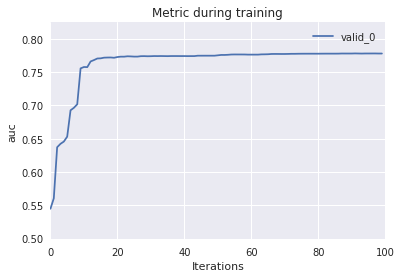

Plotting feature importances...


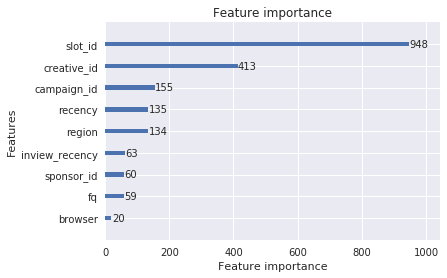

In [17]:
import lightgbm as lgb
from sklearn.preprocessing import PolynomialFeatures
num_data=len(df_final)
feature_cols = ['browser',
       'slot_id', 'sponsor_id', 'campaign_id', 'creative_id',
       'region', 'fq', 'recency', 'inview_recency']
label_col = "click_flg"
features = df_final[feature_cols]
labels = df_final[label_col]
train_x = features.iloc[0:int(num_data*0.8),:]
val_x = features.iloc[int(num_data*0.8):int(num_data*0.9),:]
test_x = features.iloc[int(num_data*0.9):num_data,:]
train_y = labels[0:int(num_data*0.8)]
val_y = labels[int(num_data*0.8):int(num_data*0.9)]
test_y = labels[int(num_data*0.9):num_data]
# 訓練・テストデータの設定
train_data = lgb.Dataset(train_x, label=train_y)
eval_data = lgb.Dataset(val_x, label=val_y, reference= train_data)

params={"objective": "binary",
        "boosting_type": "gbdt",
        'feature_fraction': 0.27914384688479543, 
        'max_depth': 73, 
        "max_bin": 256,
        'min_child_weight': 9, 
        'subsample': 0.9878747678936071, 
        'min_data_in_leaf': 428, 
        'num_leaves': 76, 
        'min_child_samples': 310, 
        'learning_rate': 0.641945204259818, 
        'drop_rate': 0.9931413183540156, 
        'lambda_l1': 6,
        "verbose": 2,
        "is_unbalance": False,
        "max_drop": 50,
        "min_split_gain": 0,
        "verbosity":-1
       }
params['metric'] = 'auc'
evals_result = {}  # to record eval results for plotting
model = lgb.train(params, train_data, valid_sets=eval_data,evals_result=evals_result, fobj=focal_loss, feval=focal_loss_eval)
print('Plotting metrics recorded during training...')
ax = lgb.plot_metric(evals_result, metric='auc')
plt.show()
print('Plotting feature importances...')
ax = lgb.plot_importance(model, max_num_features=10)
plt.show()
y_pred = model.predict(test_x, num_iteration=model.best_iteration)

In [18]:
print("AUC(ROC):{}".format(roc_auc_score(test_y,y_pred)))

AUC(ROC):0.7742782421402946


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


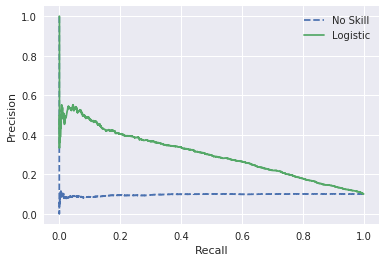

In [19]:
# precision-recall curve and f1
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from matplotlib import pyplot
import random
# generate a no skill prediction (majority class)
no_skill_probs = [i for i in np.random.rand(len(test_y))]
# calculate precision and recall for each threshold
ns_precision, ns_recall, _ = precision_recall_curve(test_y, no_skill_probs)
lr_precision, lr_recall, _ = precision_recall_curve(test_y, y_pred)

# plot the precision-recall curves
pyplot.plot(ns_recall, ns_precision, linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, linestyle='-', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [20]:
from sklearn.metrics import auc
print("AUC(PR):%s" %str(auc(lr_recall, lr_precision)))

AUC(PR):0.30033412323836317


In [78]:
y_pred_str = [str(n) for n in y_pred]
with open('lightgbm_3.txt', 'w') as rd:
    rd.writelines('\n'.join(y_pred_str))

# With Features Made by me

In [7]:
num_data=len(df_final)
feature_cols = ['browser',
       'slot_id', 'sponsor_id', 'campaign_id', 'creative_id',
       'region', 'fq', 'recency', 'inview_recency', 'request_hour',
       'request_day']
label_col = "click_flg"
features = df_final[feature_cols]
labels = df_final[label_col]
train_x = features.iloc[0:int(num_data*0.8),:]
val_x = features.iloc[int(num_data*0.8):int(num_data*0.9),:]
test_x = features.iloc[int(num_data*0.9):num_data,:]
train_y = labels[0:int(num_data*0.8)]
val_y = labels[int(num_data*0.8):int(num_data*0.9)]
test_y = labels[int(num_data*0.9):num_data]

In [8]:
class TargetEncoding_ws(object):
    """
    DFと変換したいカラムリスト、targetを引数として、Target Encoding with Smoothingを行う
    引数
    dataframe : DF全体 (pd.DataFrame)
    target : 目的変数のカラム (np.ndarray or np.Series)
    list_cols : 変換したいカラムリスト (list[str])
    k : smoothingのハイパーパラメータ (int)
    impute : 未知のカテゴリに平均を入れるか (boolean)
    """
    def __init__(self, list_cols, k=100, impute=True):
        self.df = None
        self.target = None
        self.list_cols = list_cols
        self.k = k
        self.impute = impute
        self.target_map = {}
        self.target_mean = None

    def sigmoid(self, x, k):
        return 1 / (1 + np.exp(- x / k))

    def fit_univariate(self, target, col):
        """
        一つの変数に対するTarget_Encoding
        col : TargetEncodingしたい変数名
        """
        df = self.df.copy()
        k = self.k
        df["target"] = target
        n_i = df.groupby(col).count()["target"]

        lambda_n_i = self.sigmoid(n_i, k)
        uni_map = df.groupby(col).mean()["target"]

        return lambda_n_i * df.loc[:, "target"].mean() + (1 - lambda_n_i) * uni_map

    def fit(self, data, target):
        """
        複数カラムにも対応したTargetEncoding
        """
        self.df = data.copy()
        self.target = target

        if self.impute == True:
            self.target_mean = target.mean()

        #各カラムのmapを保存
        for col in list_cols:
            self.target_map[col] = self.fit_univariate(target, col)

    def transform(self, x):
        list_cols = self.list_cols
        x_d = x.copy()
        for col in list_cols:
            x_d.loc[:, col] = x_d.loc[:, col].map(self.target_map[col])

            #impute
            if self.impute == True:
                x_d.loc[:, col] = np.where(x_d.loc[:, col].isnull(), self.target_mean, x_d.loc[:, col])

        return x_d

In [9]:
list_cols = ['browser',
       'slot_id', 'sponsor_id', 'campaign_id', 'creative_id',
       'region', 'request_hour',
       'request_day']

#list_cols = ['slot_id']


In [10]:
te = TargetEncoding_ws(list_cols=list_cols, k=300, impute=True)
te.fit(train_x, train_y)
train_x_1 = te.transform(train_x)
val_x_1 = te.transform(val_x)
test_x_1 = te.transform(test_x)

[1]	valid_0's auc: 0.5	valid_0's focal_loss: 0.24229
[2]	valid_0's auc: 0.653097	valid_0's focal_loss: 0.111847
[3]	valid_0's auc: 0.653103	valid_0's focal_loss: 0.0738018
[4]	valid_0's auc: 0.674523	valid_0's focal_loss: 0.060981
[5]	valid_0's auc: 0.776436	valid_0's focal_loss: 0.0532549
[6]	valid_0's auc: 0.777888	valid_0's focal_loss: 0.0519388
[7]	valid_0's auc: 0.777698	valid_0's focal_loss: 0.0516635
[8]	valid_0's auc: 0.778166	valid_0's focal_loss: 0.0513871
[9]	valid_0's auc: 0.775751	valid_0's focal_loss: 0.0505889
[10]	valid_0's auc: 0.771973	valid_0's focal_loss: 0.0504835
[11]	valid_0's auc: 0.772535	valid_0's focal_loss: 0.0504753
[12]	valid_0's auc: 0.770591	valid_0's focal_loss: 0.0504616
[13]	valid_0's auc: 0.784121	valid_0's focal_loss: 0.0494544
[14]	valid_0's auc: 0.784209	valid_0's focal_loss: 0.0494502
[15]	valid_0's auc: 0.784585	valid_0's focal_loss: 0.0494415
[16]	valid_0's auc: 0.784644	valid_0's focal_loss: 0.0494362
[17]	valid_0's auc: 0.784473	valid_0's foc

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


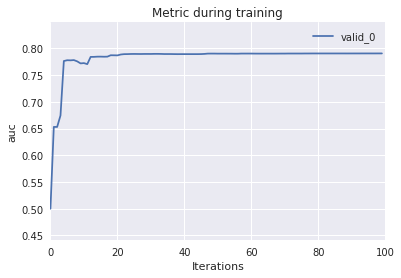

Plotting feature importances...


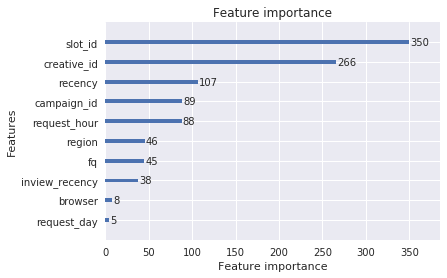

In [69]:
# 訓練・テストデータの設定
import lightgbm as lgb
train_data = lgb.Dataset(train_x_1, label=train_y)
eval_data = lgb.Dataset(val_x_1, label=val_y, reference= train_data)

params={"objective": "binary",
        "boosting_type": "gbdt",
        'feature_fraction': 0.27914384688479543, 
        'max_depth': 73, 
        "max_bin": 256,
        'min_child_weight': 9, 
        'subsample': 0.9878747678936071, 
        'min_data_in_leaf': 428, 
        'num_leaves': 76, 
        'min_child_samples': 310, 
        'learning_rate': 0.641945204259818, 
        'drop_rate': 0.9931413183540156, 
        'lambda_l1': 6,
        "verbose": 2,
        "is_unbalance": False,
        "max_drop": 50,
        "min_split_gain": 0,
        "verbosity":-1
       }
params['metric'] = 'auc'
evals_result = {}  # to record eval results for plotting
model = lgb.train(params, train_data, valid_sets=eval_data,evals_result=evals_result, fobj=focal_loss, feval=focal_loss_eval)
print('Plotting metrics recorded during training...')
ax = lgb.plot_metric(evals_result, metric='auc')
plt.show()
print('Plotting feature importances...')
ax = lgb.plot_importance(model, max_num_features=10)
plt.show()
y_pred = model.predict(test_x_1, num_iteration=model.best_iteration)

In [70]:
print(roc_auc_score(test_y, y_pred))

0.7833820015817721


In [71]:
from sklearn.metrics import roc_curve, auc
def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value

    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.ix[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 

# Find optimal probability threshold
threshold = Find_Optimal_Cutoff(test_y, y_pred)
print (threshold)
# [0.31762762459360921]

# Find prediction to the dataframe applying threshold
pred = []
for i in y_pred:
  if i>threshold:
    pred.append(1)
  else:
    pred.append(0)

# Print confusion Matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(test_y, pred)

/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:18: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


[-1.8443757714146642]


array([[13012,  4977],
       [  557,  1454]])

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


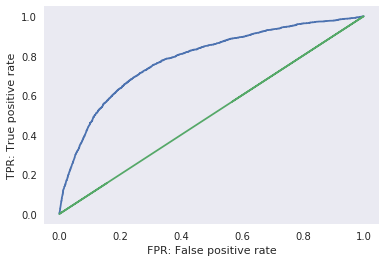

In [72]:
import pylab as pl
from sklearn import metrics
# FPR, TPR(, しきい値) を算出
roc_p = metrics.roc_curve(test_y, y_pred, drop_intermediate=False)
x = np.random.rand(len(test_y))
y = x
plt.plot(roc_p[0], roc_p[1],linestyle='-')
plt.plot(x, y)
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


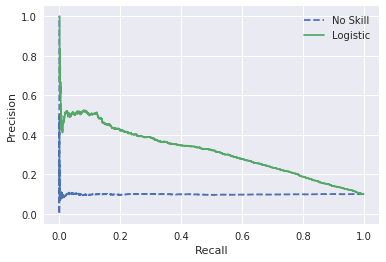

AUC(PR):0.3140476109201925


In [73]:
# precision-recall curve and f1
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from matplotlib import pyplot
import random
# generate a no skill prediction (majority class)
no_skill_probs = [i for i in np.random.rand(len(test_y))]
# calculate precision and recall for each threshold
ns_precision, ns_recall, _ = precision_recall_curve(test_y, no_skill_probs)
lr_precision, lr_recall, _ = precision_recall_curve(test_y, y_pred)

# plot the precision-recall curves
pyplot.plot(ns_recall, ns_precision, linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, linestyle='-', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()
from sklearn.metrics import auc
print("AUC(PR):%s" %str(auc(lr_recall, lr_precision)))

# Under sampling

In [11]:
# Class count
train = df_final.iloc[0:int(num_data*0.8),:]
count_class_0, count_class_1 = train.click_flg.value_counts()
# Divide by class
df_class_0 = train[train['click_flg'] == 0]
df_class_1 = train[train['click_flg'] == 1]
df_class_0_under = df_class_0.sample(int(count_class_1*2))
df_train_under = pd.concat([df_class_0_under, df_class_1], axis=0)

In [12]:
num_data=len(df_final)
feature_cols = ['browser',
       'slot_id', 'sponsor_id', 'campaign_id', 'creative_id',
       'region', 'fq', 'recency', 'inview_recency', 'request_hour',
       'request_day']
label_col = "click_flg"
train_features = df_train_under[feature_cols]
train_labels = df_train_under[label_col]
features = df_final[feature_cols]
labels = df_final[label_col]
train_x = train_features
val_x = features.iloc[int(num_data*0.8):int(num_data*0.9),:]
test_x = features.iloc[int(num_data*0.9):num_data,:]
train_y = train_labels
val_y = labels[int(num_data*0.8):int(num_data*0.9)]
test_y = labels[int(num_data*0.9):num_data]

In [13]:
list_cols = ['browser',
       'slot_id', 'sponsor_id', 'campaign_id', 'creative_id',
       'region', 'request_hour',
       'request_day']

#list_cols = ['slot_id']

te = TargetEncoding_ws(list_cols=list_cols, k=300, impute=True)
te.fit(train_x, train_y)
train_x_1 = te.transform(train_x)
val_x_1 = te.transform(val_x)
test_x_1 = te.transform(test_x)

[1]	valid_0's auc: 0.671949	valid_0's focal_loss: 0.132844
[2]	valid_0's auc: 0.781115	valid_0's focal_loss: 0.0948962
[3]	valid_0's auc: 0.77652	valid_0's focal_loss: 0.0807832
[4]	valid_0's auc: 0.787067	valid_0's focal_loss: 0.0749396
[5]	valid_0's auc: 0.786539	valid_0's focal_loss: 0.0723644
[6]	valid_0's auc: 0.787327	valid_0's focal_loss: 0.071334
[7]	valid_0's auc: 0.787117	valid_0's focal_loss: 0.0714917
[8]	valid_0's auc: 0.788493	valid_0's focal_loss: 0.0713064
[9]	valid_0's auc: 0.788474	valid_0's focal_loss: 0.0715031
[10]	valid_0's auc: 0.789101	valid_0's focal_loss: 0.0717723
[11]	valid_0's auc: 0.789477	valid_0's focal_loss: 0.0714966
[12]	valid_0's auc: 0.789743	valid_0's focal_loss: 0.0723024
[13]	valid_0's auc: 0.78982	valid_0's focal_loss: 0.0729275
[14]	valid_0's auc: 0.790282	valid_0's focal_loss: 0.0728399
[15]	valid_0's auc: 0.790255	valid_0's focal_loss: 0.0728248
[16]	valid_0's auc: 0.790632	valid_0's focal_loss: 0.0729603
[17]	valid_0's auc: 0.791056	valid_0'

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


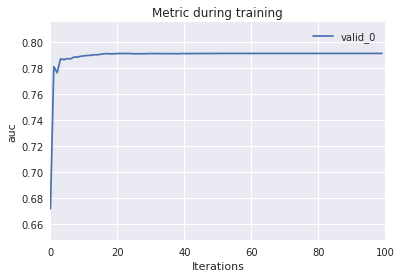

Plotting feature importances...


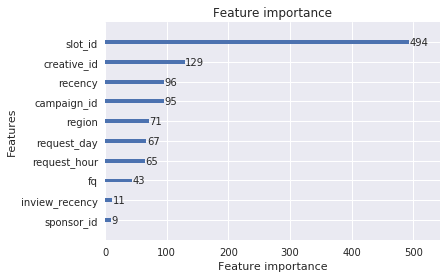

In [14]:
# 訓練・テストデータの設定
import lightgbm as lgb
train_data = lgb.Dataset(train_x_1, label=train_y)
eval_data = lgb.Dataset(val_x_1, label=val_y, reference= train_data)

params={"objective": "binary",
        "boosting_type": "gbdt",
        'feature_fraction': 0.27914384688479543, 
        'max_depth': 73, 
        "max_bin": 256,
        'min_child_weight': 9, 
        'subsample': 0.9878747678936071, 
        'min_data_in_leaf': 428, 
        'num_leaves': 76, 
        'min_child_samples': 310, 
        'learning_rate': 0.641945204259818, 
        'drop_rate': 0.9931413183540156, 
        'lambda_l1': 6,
        "verbose": 2,
        "is_unbalance": False,
        "max_drop": 50,
        "min_split_gain": 0,
        "verbosity":-1
       }
params['metric'] = 'auc'
evals_result = {}  # to record eval results for plotting
model = lgb.train(params, train_data, valid_sets=eval_data,evals_result=evals_result, fobj=focal_loss, feval=focal_loss_eval)
print('Plotting metrics recorded during training...')
ax = lgb.plot_metric(evals_result, metric='auc')
plt.show()
print('Plotting feature importances...')
ax = lgb.plot_importance(model, max_num_features=10)
plt.show()
y_pred = model.predict(test_x_1, num_iteration=model.best_iteration)

In [15]:
print(roc_auc_score(test_y, y_pred))

0.7861752854712942


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


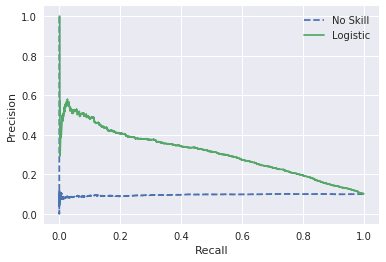

AUC(PR):0.3093812653591718


In [16]:
# precision-recall curve and f1
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from matplotlib import pyplot
import random
# generate a no skill prediction (majority class)
no_skill_probs = [i for i in np.random.rand(len(test_y))]
# calculate precision and recall for each threshold
ns_precision, ns_recall, _ = precision_recall_curve(test_y, no_skill_probs)
lr_precision, lr_recall, _ = precision_recall_curve(test_y, y_pred)

# plot the precision-recall curves
pyplot.plot(ns_recall, ns_precision, linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, linestyle='-', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()
from sklearn.metrics import auc
print("AUC(PR):%s" %str(auc(lr_recall, lr_precision)))

In [22]:
from sklearn.metrics import roc_curve, auc
def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value

    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.ix[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 

# Find optimal probability threshold
threshold = Find_Optimal_Cutoff(test_y, y_pred)
print (threshold)
# [0.31762762459360921]

# Find prediction to the dataframe applying threshold
pred = []
for i in y_pred:
  if i>threshold:
    pred.append(1)
  else:
    pred.append(0)

# Print confusion Matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(test_y, pred)

/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:18: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


[-0.9541207428550728]


array([[13031,  4958],
       [  555,  1456]])

In [23]:
def probability_calibration(y_proba, beta):
    """サンプリングレートを元に確率を補正する"""
    calibrated_proba = y_proba / (y_proba + (1 - y_proba) / beta)
    return calibrated_proba
train_y_all = labels[0:int(num_data*0.8)]
# サンプリングレートを元に確率を補正する
y_train_zero_len = train_y.sum()
beta = y_train_zero_len / len(train_y_all)
y_pred_proba_cb = probability_calibration(np.array(y_pred),beta)
# Find optimal probability threshold
threshold = Find_Optimal_Cutoff(test_y, y_pred_proba_cb)
print (threshold)

# Find prediction to the dataframe applying threshold
pred_cb = []
for i in y_pred_proba_cb:
  if i>threshold:
    pred_cb.append(1)
  else:
    pred_cb.append(0)
print(roc_auc_score(test_y, y_pred_proba_cb))
# Print confusion Matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(test_y, pred_cb)


/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:18: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


[-0.05117394686522415]
0.7868585169692768


array([[13031,  4958],
       [  555,  1456]])

# Under Bagging

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import BaseCrossValidator

In [18]:
num_data=len(df_final)
feature_cols = ['browser',
       'slot_id', 'sponsor_id', 'campaign_id', 'creative_id',
       'region', 'fq', 'recency', 'inview_recency', 'request_hour',
       'request_day']
label_col = "click_flg"
features = df_final[feature_cols]
labels = df_final[label_col]
train_x = features.iloc[0:int(num_data*0.8),:]
val_x = features.iloc[int(num_data*0.8):int(num_data*0.9),:]
test_x = features.iloc[int(num_data*0.9):num_data,:]
train_y = labels[0:int(num_data*0.8)]
val_y = labels[int(num_data*0.8):int(num_data*0.9)]
test_y = labels[int(num_data*0.9):num_data]
te = TargetEncoding_ws(list_cols=list_cols, k=300, impute=True)
te.fit(train_x, train_y)
train_x_1 = te.transform(train_x)
val_x_1 = te.transform(val_x)
test_x_1 = te.transform(test_x)

In [19]:
X = pd.concat([train_x_1, val_x_1, test_x_1])
y = pd.concat([train_y, val_y, test_y])

In [14]:
len(X)

200000

In [20]:
class ModelExtractionCallback(object):
    '''lightgbm.cv() から学習済みモデルを取り出すためのコールバックに使うクラス

    NOTE: 非公開クラス '_CVBooster' に依存しているため将来的に動かなく恐れがある
    '''

    def __init__(self):
        self._model = None

    def __call__(self, env):
        # _CVBooster の参照を保持する
        self._model = env.model

    def _assert_called_cb(self):
        if self._model is None:
            # コールバックが呼ばれていないときは例外にする
            raise RuntimeError('callback has not called yet')

    @property
    def boosters_proxy(self):
        self._assert_called_cb()
        # Booster へのプロキシオブジェクトを返す
        return self._model

    @property
    def raw_boosters(self):
        self._assert_called_cb()
        # Booster のリストを返す
        return self._model.boosters

    @property
    def best_iteration(self):
        self._assert_called_cb()
        # Early stop したときの boosting round を返す
        return self._model.best_iteration

In [21]:
import lightgbm.engine

In [22]:
from lightgbm.basic import Booster

In [23]:
class CVBooster(object):
    """"Auxiliary data struct to hold all boosters of CV."""
    def __init__(self):
        self.boosters = []
        self.best_iteration = -1

    def append(self, booster):
        """add a booster to CVBooster"""
        self.boosters.append(booster)

    def __getattr__(self, name):
        """redirect methods call of CVBooster"""
        def handlerFunction(*args, **kwargs):
            """call methods with each booster, and concatenate their results"""
            ret = []
            for booster in self.boosters:
                ret.append(getattr(booster, name)(*args, **kwargs))
            return ret
        return handlerFunction

In [24]:
def _make_n_folds(full_data, folds, nfold, params, seed, fpreproc=None, stratified=True,
                  shuffle=True, eval_train_metric=False):
    """Make a n-fold list of Booster from random indices."""
    full_data = full_data.construct()
    num_data = full_data.num_data()
    if folds is not None:
        if not hasattr(folds, '__iter__') and not hasattr(folds, 'split'):
            raise AttributeError("folds should be a generator or iterator of (train_idx, test_idx) tuples "
                                 "or scikit-learn splitter object with split method")
        if hasattr(folds, 'split'):
            group_info = full_data.get_group()
            if group_info is not None:
                group_info = np.array(group_info, dtype=np.int32, copy=False)
                flatted_group = np.repeat(range_(len(group_info)), repeats=group_info)
            else:
                flatted_group = np.zeros(num_data, dtype=np.int32)
            folds = folds.split(X=np.zeros(num_data), y=full_data.get_label(), groups=flatted_group)


    ret = CVBooster()
    for train_idx, test_idx in folds:
        train_set = full_data.subset(train_idx)
        valid_set = full_data.subset(test_idx)
        # run preprocessing on the data set if needed
        if fpreproc is not None:
            train_set, valid_set, tparam = fpreproc(train_set, valid_set, params.copy())
        else:
            tparam = params
        cvbooster = Booster(tparam, train_set)
        if eval_train_metric:
            cvbooster.add_valid(train_set, 'train')
        cvbooster.add_valid(valid_set, 'valid')
        ret.append(cvbooster)
    return ret

In [25]:
lightgbm.engine._make_n_folds =  _make_n_folds

In [26]:
class UnderBaggingKFold(BaseCrossValidator):
    """CV に使うだけで UnderBagging できる KFold 実装

    NOTE: 少ないクラスのデータは各 Fold で重複して選択される"""

    def __init__(self, n_splits=10, shuffle=True, random_states=None,
                 test_size=0.2, whole_testing=False):
        """
        :param n_splits: Fold の分割数
        :param shuffle: 分割時にデータをシャッフルするか
        :param random_states: 各 Fold の乱数シード
        :param test_size: Under-sampling された中でテスト用データとして使う割合
        :param whole_testing: Under-sampling で選ばれなかった全てのデータをテスト用データに追加するか
        """
        self.n_splits = n_splits

    def split(self, X, y=None, groups=None):
        if X.ndim < 2:
            # RandomUnderSampler#fit_resample() は X が 1d-array だと文句を言う
            X = np.vstack(X)
        # Class count
        count_class_0, count_class_1 = y.value_counts()
        X = pd.DataFrame(X)
        y = pd.DataFrame(y)
        all_data = pd.concat([X,y], axis = 1)
        train_data = all_data.iloc[0:int(num_data*0.8),:]
        test_indices = list(range(int(num_data*0.8),int(num_data*0.9)))
        # Divide by class
        df_class_0 = train_data[y == 0]
        df_class_1 = train_data[y == 1]
        for i in range(self.n_splits):
          df_class_0_under = df_class_0.sample(int(count_class_1*2))
          df_train_under = pd.concat([df_class_0_under, df_class_1], axis=0)
          train_indices = df_train_under.index

          yield np.array(train_indices), np.array(test_indices)

    def get_n_splits(self, X=None, y=None, groups=None):
        return self.n_splits

In [27]:
folds = UnderBaggingKFold()

In [23]:
# 訓練・テストデータの設定
import lightgbm as lgb
train_data = lgb.Dataset(X, y)

params={"objective": "binary",
        "boosting_type": "gbdt",
        'feature_fraction': 0.27914384688479543, 
        'max_depth': 73, 
        "max_bin": 256,
        'min_child_weight': 9, 
        'subsample': 0.9878747678936071, 
        'min_data_in_leaf': 428, 
        'num_leaves': 76, 
        'min_child_samples': 310, 
        'learning_rate': 0.641945204259818, 
        'drop_rate': 0.9931413183540156, 
        'lambda_l1': 6,
        "verbose": 2,
        "is_unbalance": False,
        "max_drop": 50,
        "min_split_gain": 0,
        "verbosity":-1
       }
params['metric'] = 'auc'
extraction_cb = ModelExtractionCallback()
callbacks = [
    extraction_cb,
]
lgb.cv(params, train_data, fobj=focal_loss, feval=focal_loss_eval,
                        folds=folds,callbacks=callbacks)

cv_booster = extraction_cb.boosters_proxy
y_pred = cv_booster.predict(test_x_1)

In [24]:
 y_pred = np.array(y_pred).mean(axis=0)

0.7848566582169296


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


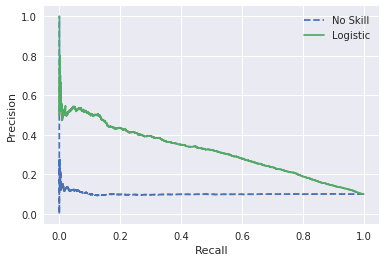

AUC(PR):0.31757227034194535


In [25]:
print(roc_auc_score(test_y, y_pred))
# precision-recall curve and f1
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from matplotlib import pyplot
import random
# generate a no skill prediction (majority class)
no_skill_probs = [i for i in np.random.rand(len(test_y))]
# calculate precision and recall for each threshold
ns_precision, ns_recall, _ = precision_recall_curve(test_y, no_skill_probs)
lr_precision, lr_recall, _ = precision_recall_curve(test_y, y_pred)

# plot the precision-recall curves
pyplot.plot(ns_recall, ns_precision, linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, linestyle='-', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()
from sklearn.metrics import auc
print("AUC(PR):%s" %str(auc(lr_recall, lr_precision)))

In [26]:
y_pred_str = [str(n) for n in y_pred]
with open('lightgbm.txt', 'w') as rd:
    rd.writelines('\n'.join(y_pred_str))

In [ ]:
!pip install optuna

In [ ]:
import optuna